In [56]:
import numpy as np
import os
from sklearn.decomposition import LatentDirichletAllocation
from scipy.sparse import csr_matrix
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [69]:
def load_data(file_path):
    with open(file_path, 'r', errors='ignore') as file:
        return [line.strip() for line in file]
    
def preprocess_data(train_data, vocabulary, min_df=2):
    rows, cols, values = [], [], []
    doc_count = np.zeros(len(vocabulary), dtype=int)
    
    for line in train_data:
        doc_id, word_id, count = map(int, line.split())
        doc_count[word_id - 1] += 1

    # Filter out words that appear in fewer than `min_df` documents
    valid_words = set(i for i, count in enumerate(doc_count) if count >= min_df)
    filtered_vocab = [vocabulary[i] for i in valid_words]
    
    for line in train_data:
        doc_id, word_id, count = map(int, line.split())
        if word_id - 1 in valid_words:
            rows.append(doc_id - 1)  # Convert to zero-indexed
            cols.append(word_id - 1)  # Convert to zero-indexed
            values.append(count)
    
    X = csr_matrix((values, (rows, cols)), shape=(len(set(rows)), len(vocabulary)))
    
    return X, filtered_vocab



In [70]:
data_dir = '../data/20newsgroup'
# Load training data
train_data = load_data(os.path.join(data_dir, 'train.data'))
train_labels = load_data(os.path.join(data_dir, 'train.label'))
vocabulary = load_data(os.path.join(data_dir, 'vocabulary.txt'))

In [75]:
X_train, filtered_vocab = preprocess_data(train_data, vocabulary)
# Train LDA model with custom logging
n_topics = 20  # Number of topics
max_iter = 100  # Maximum number of iterations
log_every = 1  # Log every 'log_every' iterations

lda = LatentDirichletAllocation(n_components=n_topics, random_state=0, learning_decay=0.7, learning_offset=50.0)
previous_perplexity = None

for i in range(max_iter):
    lda.partial_fit(X_train)
    if (i + 1) % log_every == 0:
        current_perplexity = lda.perplexity(X_train)
        print(f"Iteration {i + 1}, Perplexity: {current_perplexity}")
        
        if previous_perplexity is not None and abs(previous_perplexity - current_perplexity) < 1e-2:
            print(f"Converged at iteration {i + 1}")
            break
        
        previous_perplexity = current_perplexity

# Evaluate model using perplexity
final_perplexity = lda.perplexity(X_train)
print(f"Final Model Perplexity: {final_perplexity}")

Iteration 1, Perplexity: 2953.794246633081
Iteration 2, Perplexity: 2480.7169895279435
Iteration 3, Perplexity: 2241.429320093951
Iteration 4, Perplexity: 2102.795425472935
Iteration 5, Perplexity: 2017.54230573009
Iteration 6, Perplexity: 1961.7255393722678
Iteration 7, Perplexity: 1923.1469371693577
Iteration 8, Perplexity: 1894.9664490762646
Iteration 9, Perplexity: 1873.649376772123
Iteration 10, Perplexity: 1856.8579907842372
Iteration 11, Perplexity: 1843.3177595478542
Iteration 12, Perplexity: 1832.1398088426663
Iteration 13, Perplexity: 1822.7726909086557
Iteration 14, Perplexity: 1814.8375693977548
Iteration 15, Perplexity: 1807.9398237971047
Iteration 16, Perplexity: 1801.9249081925968
Iteration 17, Perplexity: 1796.602590790647
Iteration 18, Perplexity: 1791.8412468217816
Iteration 19, Perplexity: 1787.6402287906285
Iteration 20, Perplexity: 1783.8359865775824
Iteration 21, Perplexity: 1780.4224419992725
Iteration 22, Perplexity: 1777.292247510261
Iteration 23, Perplexity: 1

KeyboardInterrupt: 

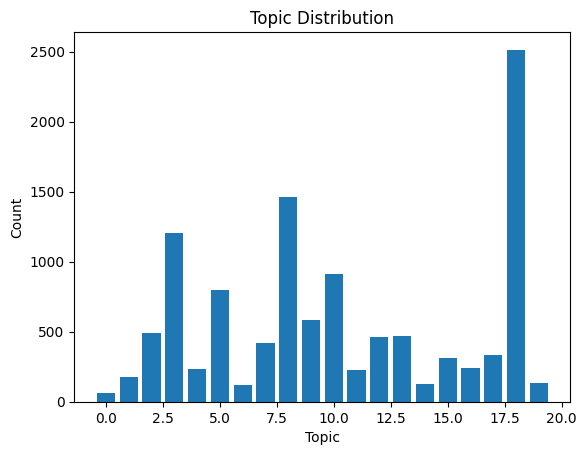

In [85]:
import matplotlib.pyplot as plt

plt.bar(range(n_topics), np.bincount(pred_labels))
plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()

In [88]:
import numpy as np
import os
from sklearn.decomposition import LatentDirichletAllocation
from scipy.sparse import csr_matrix
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from scipy.optimize import linear_sum_assignment


conf_matrix = confusion_matrix(true_labels, pred_labels)
row_ind, col_ind = linear_sum_assignment(conf_matrix.max() - conf_matrix)
optimal_labels = np.zeros_like(pred_labels)
for i, j in zip(row_ind, col_ind):
    optimal_labels[pred_labels == j] = i


In [89]:
ari = adjusted_rand_score(true_labels, optimal_labels)
nmi = normalized_mutual_info_score(true_labels, optimal_labels)

In [90]:
ari, nmi

(0.15087314677532793, 0.3531195481968254)

In [37]:
true_labels = np.array(list(map(lambda x: int(x)-1, train_labels)))

In [52]:
true_labels[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
result[:100]

array([10, 17,  0, 18, 11,  9,  5, 11, 18, 10,  9, 13, 10, 10,  1,  9,  9,
       10, 10, 14, 10, 10, 12, 14, 10, 10,  9,  5, 18, 10,  9, 14, 11, 14,
       10, 16, 14, 10,  2, 18, 17, 10, 10, 10, 10, 12, 10,  9, 10,  2, 10,
        9,  9, 10, 17,  9,  8,  9,  1, 10, 13, 12, 11, 10, 10, 10, 10,  8,
        8,  1,  3, 10, 11,  2,  9, 13, 10, 18, 10, 10, 13,  8, 10,  0, 11,
       10,  8, 10, 14,  3, 17,  2, 14, 10,  9, 19, 12,  9, 11, 16])

In [40]:
from sklearn.datasets import make_multilabel_classification

X, _ = make_multilabel_classification(random_state=0)


In [41]:
print(X.shape)

(100, 20)


In [42]:
print(X)

[[3. 1. 4. ... 4. 1. 3.]
 [5. 0. 6. ... 0. 0. 3.]
 [3. 4. 1. ... 3. 2. 5.]
 ...
 [2. 1. 2. ... 1. 0. 3.]
 [6. 4. 1. ... 1. 3. 5.]
 [2. 4. 2. ... 5. 4. 2.]]


In [43]:
lda = LatentDirichletAllocation(n_components=5,
    random_state=0)
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=0)

In [46]:
lda.transform(X).argmax(axis=1)

array([0, 3, 3, 0, 3, 3, 2, 3, 3, 0, 4, 0, 0, 3, 4, 3, 3, 0, 0, 3, 3, 2,
       3, 3, 3, 0, 0, 1, 0, 3, 1, 0, 0, 0, 2, 3, 3, 2, 1, 0, 3, 1, 0, 0,
       0, 4, 0, 1, 3, 0, 0, 0, 3, 0, 2, 2, 0, 3, 3, 2, 0, 0, 2, 3, 2, 3,
       0, 2, 2, 1, 3, 2, 3, 3, 2, 3, 2, 3, 0, 2, 2, 3, 0, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 0, 3, 0, 2, 0, 3, 3, 2])

In [47]:
lda.get_feature_names_out()

array(['latentdirichletallocation0', 'latentdirichletallocation1',
       'latentdirichletallocation2', 'latentdirichletallocation3',
       'latentdirichletallocation4'], dtype=object)

In [36]:
(np.array(list(map(lambda x: int(x)-1, train_labels))) == result).mean()

0.040997426568462156

In [17]:
print(lda.perplexity(X_train))
print(lda.score(X_train))


14.307894229251305
-7357941.844473261
[[2.48213947e-02 1.57232706e-04 1.57232708e-04 ... 1.57232708e-04
  1.57232707e-04 1.97931136e-01]
 [8.48140707e-02 7.55037598e-03 1.51800789e-01 ... 1.08058712e-01
  1.08007335e-01 1.81883592e-01]
 [1.66112957e-04 1.66112958e-04 1.66112958e-04 ... 1.66112957e-04
  9.96843854e-01 1.66112957e-04]
 ...
 [5.00000000e-02 5.00000000e-02 5.00000000e-02 ... 5.00000000e-02
  5.00000000e-02 5.00000000e-02]
 [5.00000000e-02 5.00000000e-02 5.00000000e-02 ... 5.00000000e-02
  5.00000000e-02 5.00000000e-02]
 [5.00000000e-02 5.00000000e-02 5.00000000e-02 ... 5.00000000e-02
  5.00000000e-02 5.00000000e-02]]


In [18]:
lda.transform(X_train).shape

(61188, 20)

In [19]:
(X_train.argmax(axis=1) == lda.transform(X_train).argmax(axis=1)).mean()

0.1883212394587174